# bt_gan: "deep fakes" aus MdB-Porträts

Adaptiert von https://www.kaggle.com/nageshsingh/generate-realistic-human-face-using-gan

Bildbasis: https://bilddatenbank.bundestag.de/search/picture-result?query=&filterQuery%5Bereignis%5D%5B0%5D=Portr%C3%A4t%2FPortrait&sortVal=3

<table><tr>
<td> <img src="original_mdb_sample25.png" alt="original" style="width: 450px;"/> </td>
<td> <img src="res2/generated_399.png" alt="generated" style="width: 350px;"/> </td>
</tr></table>

## Inhalt:
* [Beschreibung](#beschreibung)
* [Bilddaten einlesen](#bilddateneinlesen)
* [Neural networks erstellen](#nnerstellen)
* [GAN trainieren](#gantrainieren)
* [Ergebnisse und Diskussion](#ergebnisseunddiskussion)

## Beschreibung <a class="anchor" id="first-bullet"></a>

Wir werden "deep fake"-Gesichter aus öffentlich verfügbaren Bildern von Bundestagsabgeordneten erstellen.

Dazu wird ein GAN (Generative Adversarial Network) verwendet, ein besonderer Ansatz aus dem Bereich Machine Learning / Deep Learning mit Neural Networks (NN).

Der Clou an einem GAN: Es besteht tatsächlich aus zwei Neural Networks, die gegeneinander arbeiten. Das discriminator-NN übernimmt die Rolle einer Detektivin, während das generator-NN die Rolle einer Fälscherin übernimmt. Das generator-NN generiert zufällige Porträts, die dann mit tatsächlichen Porträts vermischt dem discriminator-NN vorgelegt werden. Das discriminator-NN muss nun entscheiden, welche Bilder Fälschungen und welche echt (also aus dem ursprünglichen Datensatz) sind. Dieser Prozess setzt sich iterativ fort: Die Entscheidungen des discriminator-NN werden dem generator-NN gegeben, welches nun versucht, neue und bessere Fälschungen zu erzeugen, die wiederum dem discriminator-NN mit echten Bildern gemischt gezeigt werden. Das discriminator-NN wird aber auch mit jeder Runde besser darin, Fälschungen von echten Bildern zu unterscheiden. Am Ende dieses oft wiederholten Spiels stehen gefälschte Porträts, die den echten Bildern in bestimmten Aspekten sehr ähnlich geworden sind.

Der untenstehende Code implementiert dies in Python/Tensorflow. Zunächst werden notwendige Bibliotheken importiert.

In [10]:
import numpy as np # linear algebra and arrays

import pandas as pd # data processing

from matplotlib import pyplot as plt # plots

import tensorflow as tf # for nn

import os 
from tqdm import tqdm # system operations

from PIL import Image as Img # image operations

from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop # keras for sequential model building

Manche Grafikkarten benötigen die nachstehende Einstellung, um RAM-Overloads zu vermeiden:

In [11]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Bilder einlesen <a class="anchor" id="bildereinlesen"></a>


Einlesen der Bilder (die Bilder sind nicht Teil des Repositorys, einige Originalbilder sind aber im Notebook zu sehen):

In [12]:
PIC_DIR = f'../bundestagportraits_centercrop/'

IMAGES_COUNT = 1684
WIDTH = 128
HEIGHT= 128

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Img.open(PIC_DIR + pic_file).convert("RGB") # "LA"
    pic.thumbnail((WIDTH, HEIGHT), Img.ANTIALIAS)
    images.append(np.uint8(pic))

100%|██████████| 1684/1684 [00:01<00:00, 1297.01it/s]


In [13]:
images = np.array(images) / 255
print(images.shape)

np.random.shuffle(images)

(1684, 128, 128, 3)


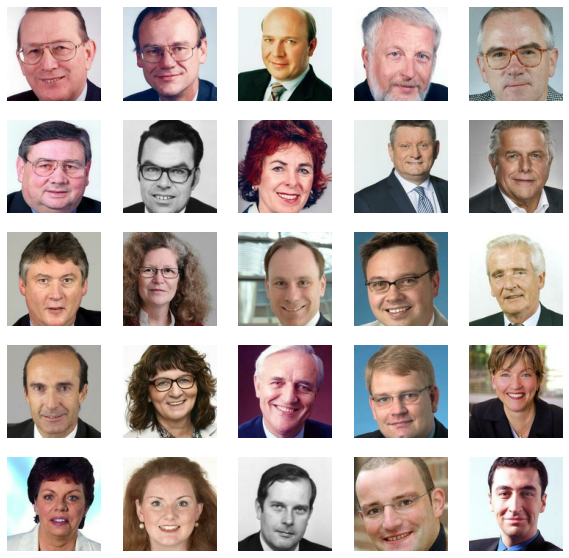

In [24]:
#Display random 25 images
fig = plt.figure(1, figsize=(10, 10))
for i in range(25):
    ir = np.random.randint(IMAGES_COUNT)
    plt.subplot(5, 5, i+1)
    plt.imshow(images[ir])
    plt.axis('off')
plt.show()
fig.savefig('original_mdb_sample25.png', bbox_inches='tight')

Die ursprünglich über 2000 Bilder waren von unterschiedlichen Abmessungen. Alle Bilder wurden automatisiert mittig (mit leichter Verschiebung nach oben) in gleich große Quadrate zugeschnitten. Anschließend wurden von Hand Bilder aussortiert, die kein oder nur wenig Gesicht zeigen und damit nicht Porträts im eigentlichen Sinn sind.

## Neural Networks erstellen <a class="anchor" id="nnerstellen"></a>


Der nachstehende Code beschreibt das erste Neural Network, das generator-NN bzw. die Fälscherin. Der Input für das generator-NN ist "white noise", d.h. ein Array aus Zufallszahlen. Der Output des generator-NN ist ein Bild mit denselben Abmessungen wie die Original-Bilder. Mit unterschiedlichem white noise-Input lassen sich später immer neue, beliebig viele Fälschungen erzeugen. Bemerkenswert ist, dass das generator-NN, also die Fälscherin, nie die echten Bilder sieht!

In [6]:
LATENT_DIM = 32
CHANNELS = 3

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

Als nächstes wird das discriminator-NN definiert, die Detektivin. Das discriminator-NN erhält als Input ein Bild mit den korrekten Abmessungen, als Output wird nur eine Zahl ausgegeben: Die Entscheidung, ob es sich um eine Fälschung oder nicht handelt.

In [7]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

In [8]:
generator = create_generator()
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       104883

In [9]:
discriminator = create_discriminator()
discriminator.trainable = False
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 126, 126, 256)     7168      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 126, 126, 256)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 256)       1048832   
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 62, 62, 256)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 256)       1048832   
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 30, 30, 256)       0   

Für das GAN werden beide NNs zusammengesetzt:

In [10]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

In [11]:
optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [12]:
gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
model (Functional)           (None, 128, 128, 3)       14953987  
_________________________________________________________________
model_1 (Functional)         (None, 1)                 4211713   
Total params: 19,165,700
Trainable params: 14,953,987
Non-trainable params: 4,211,713
_________________________________________________________________


## GAN trainieren <a class="anchor" id="gantrainieren"></a>


Nun folgt das Training des NN (dauert ein Weilchen...). Je nach Power der Grafikkarte(n) können hier größere Batchsizes eingesetzt werden. Ein Batch ist die Anzahl der Bilder, die die Grafikkarte gleichzeitig durch das NN schieben kann, um die Parameter des NN upzudaten (insgesamt knapp 15 Mio. trainierbare Parameter!). Alle 50 Iterationen wird ein Bild gespeichert, dass die aktuellen Fälschungen des generator-NN repräsentiert.

In [13]:
import time
iters = 20000
batch_size = 8

RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0
        np.random.shuffle(images)

    if step % 50 == 49:
        gan.save_weights('gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Img.fromarray(np.uint8(control_image * 255))#.save(StringIO(), 'jpeg')
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

50/20000: d_loss: 0.6287,  a_loss: 1.2977.  (1.2 sec)
100/20000: d_loss: 0.6604,  a_loss: 0.7833.  (1.2 sec)
150/20000: d_loss: 0.6987,  a_loss: 0.7448.  (1.2 sec)
200/20000: d_loss: 0.6707,  a_loss: 0.7626.  (1.2 sec)
250/20000: d_loss: 0.6989,  a_loss: 0.8521.  (1.2 sec)
300/20000: d_loss: 0.6814,  a_loss: 0.8524.  (1.3 sec)
350/20000: d_loss: 0.6496,  a_loss: 0.9053.  (1.2 sec)
400/20000: d_loss: 0.6532,  a_loss: 0.9889.  (1.2 sec)
450/20000: d_loss: 0.6818,  a_loss: 0.7508.  (1.2 sec)
500/20000: d_loss: 0.6373,  a_loss: 1.0637.  (1.2 sec)
550/20000: d_loss: 0.6782,  a_loss: 1.2143.  (1.2 sec)
600/20000: d_loss: 0.6722,  a_loss: 0.8336.  (1.2 sec)
650/20000: d_loss: 0.5994,  a_loss: 1.8455.  (1.2 sec)
700/20000: d_loss: 0.6436,  a_loss: 0.9319.  (1.2 sec)
750/20000: d_loss: 0.6568,  a_loss: 0.9417.  (1.2 sec)
800/20000: d_loss: 0.5270,  a_loss: 1.5665.  (1.3 sec)
850/20000: d_loss: 0.5354,  a_loss: 0.8269.  (1.3 sec)
900/20000: d_loss: 0.4796,  a_loss: 1.6908.  (1.2 sec)
950/20000: 

7400/20000: d_loss: 0.5784,  a_loss: 1.6822.  (1.2 sec)
7450/20000: d_loss: 0.6825,  a_loss: 1.2450.  (1.2 sec)
7500/20000: d_loss: 0.9964,  a_loss: 0.8392.  (1.2 sec)
7550/20000: d_loss: 0.5780,  a_loss: 1.3926.  (1.2 sec)
7600/20000: d_loss: 0.6413,  a_loss: 0.9915.  (1.2 sec)
7650/20000: d_loss: 0.4650,  a_loss: 0.7640.  (1.2 sec)
7700/20000: d_loss: 0.5546,  a_loss: 0.8803.  (1.2 sec)
7750/20000: d_loss: 0.6050,  a_loss: 1.4970.  (1.2 sec)
7800/20000: d_loss: 0.5705,  a_loss: 1.0648.  (1.2 sec)
7850/20000: d_loss: 0.4617,  a_loss: 1.1824.  (1.2 sec)
7900/20000: d_loss: 0.7639,  a_loss: 1.5874.  (1.3 sec)
7950/20000: d_loss: 0.5396,  a_loss: 1.1066.  (1.2 sec)
8000/20000: d_loss: 0.9064,  a_loss: 1.6833.  (1.2 sec)
8050/20000: d_loss: 0.5777,  a_loss: 1.9350.  (1.2 sec)
8100/20000: d_loss: 0.6763,  a_loss: 1.1116.  (1.2 sec)
8150/20000: d_loss: 0.7041,  a_loss: 1.7825.  (1.2 sec)
8200/20000: d_loss: 0.3815,  a_loss: 1.3900.  (1.3 sec)
8250/20000: d_loss: 0.4203,  a_loss: 1.2414.  (1

14650/20000: d_loss: 0.6796,  a_loss: 2.4875.  (1.2 sec)
14700/20000: d_loss: 0.3671,  a_loss: 2.1516.  (1.3 sec)
14750/20000: d_loss: 0.2426,  a_loss: 1.6288.  (1.2 sec)
14800/20000: d_loss: 0.5459,  a_loss: 2.1025.  (1.2 sec)
14850/20000: d_loss: 0.3719,  a_loss: 2.2471.  (1.2 sec)
14900/20000: d_loss: 0.5124,  a_loss: 2.6817.  (1.2 sec)
14950/20000: d_loss: 0.7121,  a_loss: 1.4420.  (1.3 sec)
15000/20000: d_loss: 0.4583,  a_loss: 2.5084.  (1.2 sec)
15050/20000: d_loss: 0.2839,  a_loss: 1.6832.  (1.2 sec)
15100/20000: d_loss: 0.3751,  a_loss: 1.4758.  (1.2 sec)
15150/20000: d_loss: 0.2411,  a_loss: 2.2686.  (1.2 sec)
15200/20000: d_loss: 0.4766,  a_loss: 2.0219.  (1.2 sec)
15250/20000: d_loss: 0.3566,  a_loss: 2.9308.  (1.2 sec)
15300/20000: d_loss: 0.3036,  a_loss: 1.7999.  (1.2 sec)
15350/20000: d_loss: 0.5371,  a_loss: 1.9768.  (1.2 sec)
15400/20000: d_loss: 0.4623,  a_loss: 1.7363.  (1.2 sec)
15450/20000: d_loss: 0.4735,  a_loss: 2.3519.  (1.2 sec)
15500/20000: d_loss: 0.4012,  a

Wir können die Entwicklung der Treffsicherheit der Detektivin (des discriminator-NNs) darstellen (Plot links). Es wird deutlich, dass die Treffsicherheit abnimmt mit fortschreitenden Iterationschritten, aber es gibt auch eine sehr große Varianz in der Trefferrate.

Auf der anderen Seite wird der Fortschritt der Fälscherin bzw. des generator-NN (Plot rechts) gemessen an der Fähigkeit, das discriminator-NN von der Echtheit der Fälschungen zu überzeugen. Auch hier zeigt sich eine große Varianz, aber ein Fortschritt in die richtige Richtung (bessere Fäschungen).

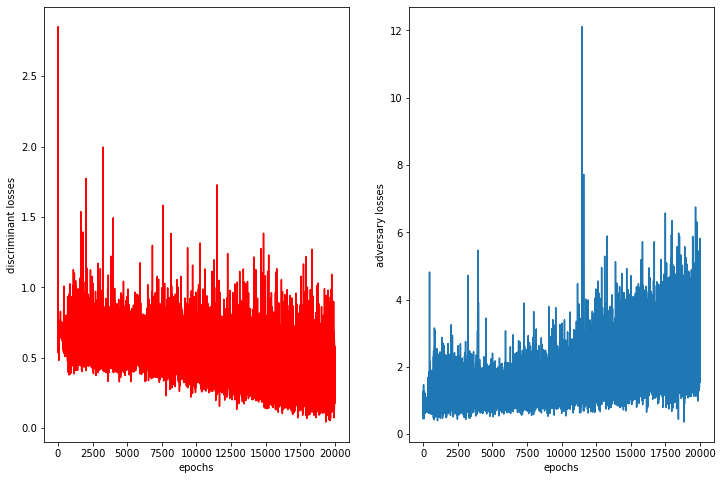

In [14]:
plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses, color='red')
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

## Ergebnisse und Diskussion <a class="anchor" id="ergebnisseunddiskussion"></a>


Zum Ende eine Sichtung der Ergebnisse. Die ersten Versuche der Fälscherin/des generator-NN haben wenig Ähnlichkeit mit den originalen Bildern, zeigen aber grundsätzliche Eigenschaften eines Porträts: Schulterpartie, Hintergrund, Farbe der Haut, grundsätzliche Position von Haaren, Mund und Augen.

<table><tr>
<td> <img src="res2/generated_0.png" alt="50 Iterationen" style="width: 250px;"/> </td>
<td> <img src="res2/generated_1.png" alt="100 Iterationen" style="width: 250px;"/> </td>
<td> <img src="res2/generated_4.png" alt="250 Iterationen" style="width: 250px;"/> </td>
<td> <img src="res2/generated_9.png" alt="500 Iterationen" style="width: 250px;"/> </td>
</tr></table>

Nach jeweils 5.000, 10.000, 15.000 Iterationen und zum Ende bei etwa 20.000 Iterationen stimmt die grundsätzliche Struktur der generierten Bilder ziemlich gut. Nach 10.000 Iterationen verbessern sich die Bilder kaum noch:

<table><tr>
<td> <img src="res2/generated_99.png" alt="5.000 Iterationen" style="width: 250px;"/> </td>
<td> <img src="res2/generated_199.png" alt="10.000 Iterationen" style="width: 250px;"/> </td>
<td> <img src="res2/generated_299.png" alt="15.000 Iterationen" style="width: 250px;"/> </td>
<td> <img src="res2/generated_399.png" alt="20.000 Iterationen" style="width: 250px;"/> </td>
</tr></table>

Es wird aber auch deutlich, dass die Bilder weit entfernt sind von echt-wirkenden "Deep Fakes": Zum Teil stimmt die Anzahl von Augen/Mündern nicht, schwarz-weiß-Bilder und Farbfotos werden nicht unterschieden vom GAN, Brillen stellen ein Problem dar usw.

Mögliche Ansätze, um diese Probleme zu lösen, sind: alle Bilder nur schwarz-weiß berücksichtigen, größeren Datensatz verwenden oder den Datensatz künstlich erweitern (z.B. durch Spiegeln der Aufnahmen).

Ein weiterer wichtiger Aspekt, der schon jetzt deutlich wird: die "besten" generierten Bilder repräsentieren diese, die im ursprünglichen Datensatz am häufigsten vorhanden sind. Mit anderen Worten, *weiße*, meist männliche Menschen mit Kurzhaarschnitten. Brillen, Langhaarfrisuren und nicht-*weiße* Hautfarben stellen das NN vor Schwierigkeiten auf Grund der Zusammensetzung des Datensatzes.

In [6]:
# dieser Code erzeugt ein gif aus den iterativen Ergebnissen -- wird aber sehr groß! >100MB
import imageio
import shutil
import os
import glob
images_to_gif = []
RES_DIR = 'res2/'
files = list(filter(os.path.isfile, glob.glob(RES_DIR + "*")))
# files = os.listdir(RES_DIR)
files.sort(key=lambda x: os.path.getmtime(x))
for filename in files:
    images_to_gif.append(imageio.imread(filename))
imageio.mimsave('training.gif', images_to_gif)
# shutil.rmtree(RES_DIR)